# 문제 1번

In [14]:
from keras.datasets import mnist

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Preprocessing

In [16]:
from keras.utils import to_categorical

X_train = X_train.reshape(-1, 28*28) / 255.
X_test = X_test.reshape(-1, 28*28) / 255.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
X_test.shape

(10000, 784)

In [18]:
y_test.shape

(10000, 10)

## Modeling

In [19]:
from keras.models import Sequential
from keras.layers import Dense

In [20]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(784,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [22]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.25)

Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 2s 55us/step - loss: 0.4375 - acc: 0.8723 - val_loss: 0.2160 - val_acc: 0.9379
Epoch 2/10
45000/45000 [==============================] - 2s 42us/step - loss: 0.1863 - acc: 0.9459 - val_loss: 0.1833 - val_acc: 0.9483
Epoch 3/10
45000/45000 [==============================] - 2s 40us/step - loss: 0.1385 - acc: 0.9599 - val_loss: 0.1474 - val_acc: 0.9559
Epoch 4/10
45000/45000 [==============================] - 2s 45us/step - loss: 0.1138 - acc: 0.9660 - val_loss: 0.1434 - val_acc: 0.9575
Epoch 5/10
45000/45000 [==============================] - 2s 42us/step - loss: 0.0943 - acc: 0.9717 - val_loss: 0.1288 - val_acc: 0.9619
Epoch 6/10
45000/45000 [==============================] - 2s 44us/step - loss: 0.0791 - acc: 0.9768 - val_loss: 0.1305 - val_acc: 0.9615
Epoch 7/10
45000/45000 [==============================] - 2s 42us/step - loss: 0.0688 - acc: 0.9794 - val_loss: 0.1226 - val_acc

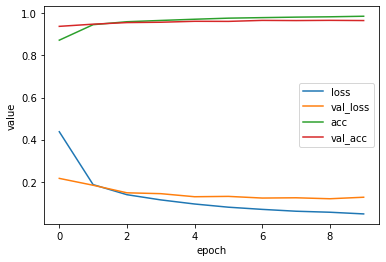

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend(loc='best')

In [24]:
y_pred = model.predict_classes(X_test)

In [25]:
y_pred = to_categorical(y_pred)

In [26]:
from sklearn.metrics import accuracy_score

print('정확도: {:.3f}'.format(accuracy_score(y_test, y_pred)))

정확도: 0.971


# 문제 2번

## load_gym

In [1]:
import gym

env = gym.make('CartPole-v0')

## Modeling

In [3]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(4,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='linear'))

In [4]:
model.compile(optimizer='adam', loss='mse')

W0919 10:43:52.406126  5128 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


## 버퍼 지정

In [6]:
import collections

memory = collections.deque(maxlen = 10000)

## 사전 학습

In [7]:
s = env.reset()

In [8]:
for i in range(32):
    action = env.action_space.sample() # np.random.randint(2)
    s2, r, done, _ = env.step(action)
    
    memory.append([s, action, r, done, s2])
    
    s = env.reset() if done else s2 # done 이면 리셋

In [9]:
len(memory)

32

## 학습 실행

In [10]:
epsilon = 1.0 # 처음에는 탐험만 수행한다. (랜덤 행동)
gamma = 0.99 # 감쇠율 (discount factor, 미래 보상을 얼마나 중요시할 지를 결정)
returns = [] # 에피소드 당 총보상값을 저장한다
count = 0

In [11]:
for episode in range(500):
    
    total_reward = 0 # 에피소스당 총보상값
    
    s = env.reset()
    
    for i in range(200): # 한 에피소드당 최대 200번만 행동한다
        
        ### 탐험 확률 지정 (1 부터 시작해서 점점 낮아지다 최소값은 1%)
        epsilon = 0.01 + (1-0.01)*np.exp(-0.0001*count)
        count += 1
        
        if np.random.rand() < epsilon:
            action = env.action_space.sample() # 랜덤 행동
        else:
            action = np.argmax(model.predict(s.reshape(1,4))[0]) # Q값이 높은 행동 선택
            
        s2, r, done, _ = env.step(action)
        
        total_reward += r
        
        memory.append([s, action, r, done, s2])
        
        ### 학습 (배치크기는 32)
        indices = np.random.choice(len(memory), 32, replace=False)
        samples = [memory[i] for i in indices]
        
        X = np.zeros([32,4]) # 입력 상태값
        y = np.zeros([32,2]) # 목표 Q값
        
        for i, sample in enumerate(samples): # sample -> [s,a,r,done,s2]
            X[i] = sample[0]
            y[i] = model.predict(sample[0].reshape(1,4))[0]
            
            if sample[3] == True: # done
                y[i][sample[1]] = sample[2]
            else:
                y[i][sample[1]] = sample[2] + gamma*np.max(model.predict(sample[-1].reshape(1,4))[0])
                
        model.fit(X, y, epochs=1, verbose=False)
        
        if done:
            break
        else:
            s = s2

    if total_reward == 200:
        print('Episode: %d, Reward: %d, Epsilon: %.5f' % (episode+1, total_reward, epsilon))
        returns.append(total_reward)
        break
    else:
        print('Episode: %d, Reward: %d, Epsilon: %.5f' % (episode+1, total_reward, epsilon))
        returns.append(total_reward)

W0919 10:44:01.238992  5128 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0919 10:44:01.240988  5128 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



Episode: 1, Reward: 34, Epsilon: 0.99674
Episode: 2, Reward: 17, Epsilon: 0.99506
Episode: 3, Reward: 14, Epsilon: 0.99368
Episode: 4, Reward: 11, Epsilon: 0.99260
Episode: 5, Reward: 34, Epsilon: 0.98927
Episode: 6, Reward: 34, Epsilon: 0.98594
Episode: 7, Reward: 22, Epsilon: 0.98380
Episode: 8, Reward: 15, Epsilon: 0.98234
Episode: 9, Reward: 20, Epsilon: 0.98040
Episode: 10, Reward: 11, Epsilon: 0.97933
Episode: 11, Reward: 21, Epsilon: 0.97730
Episode: 12, Reward: 19, Epsilon: 0.97546
Episode: 13, Reward: 56, Epsilon: 0.97007
Episode: 14, Reward: 24, Epsilon: 0.96777
Episode: 15, Reward: 15, Epsilon: 0.96633
Episode: 16, Reward: 12, Epsilon: 0.96518
Episode: 17, Reward: 16, Epsilon: 0.96366
Episode: 18, Reward: 104, Epsilon: 0.95379
Episode: 19, Reward: 29, Epsilon: 0.95106
Episode: 20, Reward: 12, Epsilon: 0.94993
Episode: 21, Reward: 22, Epsilon: 0.94786
Episode: 22, Reward: 41, Epsilon: 0.94403
Episode: 23, Reward: 20, Epsilon: 0.94216
Episode: 24, Reward: 25, Epsilon: 0.93983


## 게임 테스트

In [12]:
for epoch in range(5):
    env.reset()
    
    done = False
    n = 0
    while not done:
        a = np.argmax(model.predict(s.reshape(1,4))[0])
        s, r, done, info = env.step(a)
        n += 1
        env.render()
        
    print('Epoch: %d, Count: %d' % (epoch+1, n))
    print(s, r, done, info)

Epoch: 1, Count: 200
[ 1.92816835  1.84725366  0.17989148 -0.0732778 ] 1.0 True {'TimeLimit.truncated': True}
Epoch: 2, Count: 200
[-1.51189578 -1.50089262 -0.1521234  -0.11701788] 1.0 True {'TimeLimit.truncated': True}
Epoch: 3, Count: 200
[-0.33190939 -0.38521077 -0.05431959  0.13789518] 1.0 True {'TimeLimit.truncated': True}
Epoch: 4, Count: 200
[-0.75084345 -0.76578144 -0.08446102 -0.120728  ] 1.0 True {'TimeLimit.truncated': True}
Epoch: 5, Count: 200
[1.51912138 1.11997732 0.12545976 0.37173244] 1.0 True {'TimeLimit.truncated': True}


In [13]:
env.close()

# 문제 3번

## Preprocessing

In [1]:
from keras.datasets import mnist
import pandas as pd

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train / 255
X_test = X_test / 255

In [4]:
X_train = X_train[y_train == 7].reshape(-1, 28, 28, 1)
X_test = X_test[y_test == 7].reshape(-1, 28, 28, 1)

## Modeling

### 판별자 정의

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [8]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()

W0919 11:20:22.115376  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 11:20:22.129339  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 11:20:22.134325  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
__________

In [9]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])

W0919 11:20:23.577464  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0919 11:20:23.582452  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0919 11:20:23.587446  8972 deprecation.py:323] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 생성자 정의

In [10]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()

W0919 11:20:25.019642  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0919 11:20:25.138290  8972 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

### 적대망 정의

In [11]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [12]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

### 훈련하기

In [13]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(1000): # 1000번 학습한다.
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')

C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00001,  [0.6956509, 0.171875, 0.9882995, 0.0]


C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step: 00002,  [0.6240089, 0.78125, 1.0506119, 0.0]
Step: 00003,  [0.48216328, 1.0, 1.5974619, 0.0]
Step: 00004,  [0.32872373, 0.9921875, 1.6152879, 0.0]
Step: 00005,  [0.18176392, 1.0, 3.6073284, 0.0]
Step: 00006,  [0.21964575, 0.953125, 1.4319453, 0.0]
Step: 00007,  [0.10245639, 1.0, 2.8972998, 0.0]
Step: 00008,  [0.089753784, 0.9921875, 1.9222612, 0.0]
Step: 00009,  [0.047468193, 1.0, 1.536603, 0.0]
Step: 00010,  [0.038211513, 1.0, 1.1864903, 0.0]
Step: 00011,  [0.03679274, 0.9921875, 0.8800403, 0.1875]
Step: 00012,  [0.02365752, 1.0, 1.0049875, 0.109375]
Step: 00013,  [0.029862061, 0.9921875, 0.7725997, 0.359375]
Step: 00014,  [0.03381638, 1.0, 2.0867033, 0.0]
Step: 00015,  [0.05688642, 0.9921875, 1.4982045, 0.0]
Step: 00016,  [0.063565634, 0.9921875, 5.9328957, 0.0]
Step: 00017,  [0.28727263, 0.90625, 0.44437504, 0.921875]
Step: 00018,  [1.2599041, 0.5, 5.6201854, 0.0]
Step: 00019,  [0.39863083, 0.875, 3.6007872, 0.0]
Step: 00020,  [0.33374742, 0.9609375, 3.7047825, 0.0]
Step: 0002

Step: 00155,  [0.5865792, 0.6484375, 2.0572162, 0.0]
Step: 00156,  [0.6532361, 0.5390625, 0.55066335, 0.78125]
Step: 00157,  [0.71711326, 0.515625, 1.9732776, 0.0]
Step: 00158,  [0.70542467, 0.5, 0.59248054, 0.6875]
Step: 00159,  [0.6748365, 0.5390625, 1.507153, 0.0]
Step: 00160,  [0.5783174, 0.6796875, 0.89075595, 0.25]
Step: 00161,  [0.57155716, 0.734375, 1.3782848, 0.0]
Step: 00162,  [0.5263894, 0.8125, 0.8715911, 0.234375]
Step: 00163,  [0.53487766, 0.7578125, 1.6041318, 0.0]
Step: 00164,  [0.54157996, 0.7421875, 0.83006394, 0.296875]
Step: 00165,  [0.5539709, 0.6640625, 1.8825221, 0.0]
Step: 00166,  [0.5899048, 0.609375, 0.5376961, 0.78125]
Step: 00167,  [0.6570438, 0.53125, 1.627873, 0.0]
Step: 00168,  [0.5833025, 0.640625, 0.73179734, 0.484375]
Step: 00169,  [0.6085633, 0.6171875, 1.252309, 0.0]
Step: 00170,  [0.5904186, 0.671875, 0.6177491, 0.671875]
Step: 00171,  [0.6085792, 0.5703125, 1.2882197, 0.0]
Step: 00172,  [0.605795, 0.6328125, 0.7021882, 0.53125]
Step: 00173,  [0.588

Step: 00304,  [0.5982996, 0.7421875, 0.6626049, 0.59375]
Step: 00305,  [0.6135443, 0.6875, 0.7516565, 0.390625]
Step: 00306,  [0.59843373, 0.7421875, 0.8307295, 0.1875]
Step: 00307,  [0.6299803, 0.7265625, 0.82747835, 0.1875]
Step: 00308,  [0.59989727, 0.734375, 0.7475211, 0.421875]
Step: 00309,  [0.60053205, 0.7578125, 0.7436117, 0.4375]
Step: 00310,  [0.64770806, 0.6328125, 0.8900292, 0.078125]
Step: 00311,  [0.61893475, 0.65625, 0.44825387, 0.921875]
Step: 00312,  [0.694406, 0.5703125, 1.5744776, 0.0]
Step: 00313,  [0.7736819, 0.5, 0.43519634, 0.984375]
Step: 00314,  [0.6557321, 0.53125, 0.9410148, 0.03125]
Step: 00315,  [0.671603, 0.546875, 0.7193035, 0.390625]
Step: 00316,  [0.61373305, 0.71875, 0.9789368, 0.03125]
Step: 00317,  [0.6000899, 0.78125, 0.84709877, 0.1875]
Step: 00318,  [0.6037182, 0.7109375, 1.0537494, 0.0625]
Step: 00319,  [0.5958023, 0.75, 0.5540737, 0.84375]
Step: 00320,  [0.6156622, 0.6015625, 1.0952241, 0.03125]
Step: 00321,  [0.630989, 0.578125, 0.4063117, 0.96

Step: 00450,  [0.67327267, 0.578125, 0.9323681, 0.03125]
Step: 00451,  [0.65851855, 0.640625, 0.7197881, 0.421875]
Step: 00452,  [0.6166427, 0.71875, 0.9798709, 0.109375]
Step: 00453,  [0.64947045, 0.6171875, 0.7150699, 0.46875]
Step: 00454,  [0.67421305, 0.5625, 0.9253803, 0.125]
Step: 00455,  [0.6204681, 0.6328125, 0.62917995, 0.671875]
Step: 00456,  [0.64807487, 0.6015625, 0.9949943, 0.015625]
Step: 00457,  [0.6761778, 0.5234375, 0.56177354, 0.8125]
Step: 00458,  [0.6344741, 0.6171875, 1.1136432, 0.015625]
Step: 00459,  [0.6742537, 0.5625, 0.5933366, 0.6875]
Step: 00460,  [0.6547948, 0.5625, 1.1667365, 0.03125]
Step: 00461,  [0.68134016, 0.53125, 0.55110276, 0.859375]
Step: 00462,  [0.6724532, 0.5703125, 0.9218397, 0.046875]
Step: 00463,  [0.6318907, 0.6328125, 0.59815675, 0.8125]
Step: 00464,  [0.6681918, 0.5703125, 0.92958325, 0.078125]
Step: 00465,  [0.6267562, 0.6328125, 0.6975212, 0.46875]
Step: 00466,  [0.63338625, 0.609375, 0.94411767, 0.125]
Step: 00467,  [0.6469481, 0.625, 

Step: 00595,  [0.64142287, 0.6015625, 0.6723182, 0.59375]
Step: 00596,  [0.6211891, 0.6640625, 1.0279398, 0.125]
Step: 00597,  [0.63377017, 0.6328125, 0.61270446, 0.6875]
Step: 00598,  [0.67315733, 0.5859375, 1.1751016, 0.03125]
Step: 00599,  [0.674301, 0.546875, 0.601017, 0.765625]
Step: 00600,  [0.6488496, 0.5390625, 1.0719994, 0.046875]
Step: 00601,  [0.64639544, 0.5546875, 0.64152306, 0.609375]
Step: 00602,  [0.6118854, 0.6796875, 0.83741635, 0.3125]
Step: 00603,  [0.63329095, 0.65625, 0.86288774, 0.15625]
Step: 00604,  [0.61135733, 0.6875, 0.75174385, 0.390625]
Step: 00605,  [0.6154981, 0.7109375, 0.818856, 0.359375]
Step: 00606,  [0.5913003, 0.703125, 0.693185, 0.46875]
Step: 00607,  [0.6212877, 0.640625, 0.86212677, 0.265625]
Step: 00608,  [0.60691786, 0.71875, 0.6928446, 0.515625]
Step: 00609,  [0.6347122, 0.640625, 0.88728034, 0.234375]
Step: 00610,  [0.6464761, 0.5859375, 0.94189507, 0.25]
Step: 00611,  [0.60540366, 0.65625, 1.1167755, 0.015625]
Step: 00612,  [0.6301718, 0.59

Step: 00740,  [0.62062275, 0.671875, 0.6736311, 0.578125]
Step: 00741,  [0.6490454, 0.5703125, 1.2052022, 0.03125]
Step: 00742,  [0.675794, 0.5859375, 0.55873764, 0.796875]
Step: 00743,  [0.6643596, 0.5859375, 1.2141844, 0.015625]
Step: 00744,  [0.65579027, 0.5703125, 0.588382, 0.8125]
Step: 00745,  [0.6465981, 0.5390625, 1.0918384, 0.046875]
Step: 00746,  [0.68038255, 0.5078125, 0.6016065, 0.734375]
Step: 00747,  [0.6342841, 0.6484375, 1.2130017, 0.09375]
Step: 00748,  [0.6565712, 0.6015625, 0.6533984, 0.640625]
Step: 00749,  [0.64480704, 0.625, 1.028418, 0.0625]
Step: 00750,  [0.6570065, 0.6328125, 0.6653913, 0.59375]
Step: 00751,  [0.6146652, 0.703125, 1.0221081, 0.171875]
Step: 00752,  [0.6071993, 0.6796875, 0.7569144, 0.3125]
Step: 00753,  [0.6569921, 0.65625, 0.79235905, 0.28125]
Step: 00754,  [0.6070132, 0.765625, 0.87057316, 0.3125]
Step: 00755,  [0.6317131, 0.6796875, 0.75585645, 0.34375]
Step: 00756,  [0.5805783, 0.796875, 0.9927432, 0.21875]
Step: 00757,  [0.65983605, 0.5546

Step: 00885,  [0.6919444, 0.5546875, 1.3719312, 0.0]
Step: 00886,  [0.7211169, 0.515625, 0.5550257, 0.84375]
Step: 00887,  [0.65539384, 0.59375, 1.1405666, 0.09375]
Step: 00888,  [0.65912306, 0.578125, 0.6241409, 0.671875]
Step: 00889,  [0.6500027, 0.59375, 1.0729259, 0.078125]
Step: 00890,  [0.64129925, 0.625, 0.68252265, 0.53125]
Step: 00891,  [0.6060857, 0.6640625, 0.90761554, 0.21875]
Step: 00892,  [0.6397723, 0.578125, 0.62822926, 0.75]
Step: 00893,  [0.61624116, 0.6484375, 1.0213215, 0.0625]
Step: 00894,  [0.66209424, 0.578125, 0.6629594, 0.640625]
Step: 00895,  [0.6165705, 0.6328125, 1.091748, 0.046875]
Step: 00896,  [0.6481091, 0.59375, 0.68810284, 0.484375]
Step: 00897,  [0.631613, 0.6328125, 1.0815884, 0.046875]
Step: 00898,  [0.67248064, 0.5625, 0.5541723, 0.796875]
Step: 00899,  [0.6422961, 0.609375, 1.071239, 0.109375]
Step: 00900,  [0.63892615, 0.6328125, 0.7734226, 0.40625]
Step: 00901,  [0.65972257, 0.6015625, 0.89300853, 0.25]
Step: 00902,  [0.6658, 0.5703125, 0.833196

In [14]:
generator.save('gan_mnist_generator_1000.h5')

### 숫자 이미지 생성

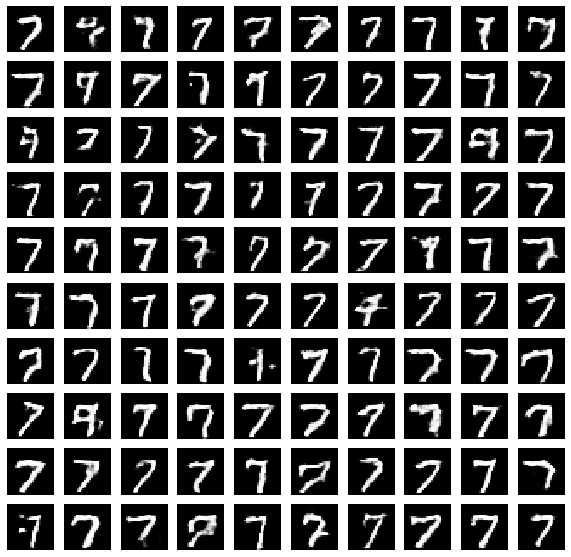

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

# 문제 4번

In [1]:
import numpy as np
X = np.array([[1,2,3], [2,3,4], [3,4,5], [4,5,6]])
y = np.array([4,5,6,10])

In [2]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(3,1)))
model.add(Dense(1))

model.summary()

Using TensorFlow backend.
W0919 17:48:36.629461  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 17:48:36.645454  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 17:48:36.647419  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [3]:
model.compile(loss='mse', optimizer='adam')

W0919 17:48:36.925970  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [4]:
model.fit(X[:,:,np.newaxis], y, epochs=1000, verbose=False)

W0919 17:48:37.196272  3372 deprecation.py:323] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0919 17:48:37.821573  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0919 17:48:37.922336  3372 deprecation_wrapper.py:119] From C:\Users\Administrator\.conda\envs\multicampus\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [5]:
model.predict(np.array([[5,6,7]]).reshape(1,3,1))

array([[12.609581]], dtype=float32)